In [1]:
!unzip -q /content/archive.zip

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf

In [3]:
data_train = pd.read_csv('/content/Stock_Price_Train.csv')
data_test = pd.read_csv('/content/Stock_Price_Test.csv')

In [4]:
data_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [7]:
print(data_train.shape,data_test.shape)

(1258, 6) (20, 6)


In [5]:
data_train.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
data_train.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

In [10]:
data_train.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [27]:
data = data_train.iloc[:,1:2].values


In [28]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range =(0,1))
data_scaled = sc.fit_transform(data)

In [29]:
x_train = []
y_train =[]

for i in range(60,1258):
    x_train.append(data_scaled[i-60:i,0])
    y_train.append(data_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)   
#reshaping 
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))

In [30]:
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,Dropout


In [31]:
regressor = Sequential()

In [32]:
regressor.add(SimpleRNN(units =50,return_sequences = True,input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(0.2))

#adding 2nd layer
regressor.add(SimpleRNN(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#adding 3rd layer 
regressor.add(SimpleRNN(units =50,return_sequences = True))
regressor.add(Dropout(0.3))

#adding fourth layer
regressor.add(SimpleRNN(units =50))
regressor.add(Dropout(0.3))

In [33]:
regressor.add(Dense(units =1))

In [34]:
regressor.compile(optimizer = 'adam' ,loss = 'mean_squared_error')

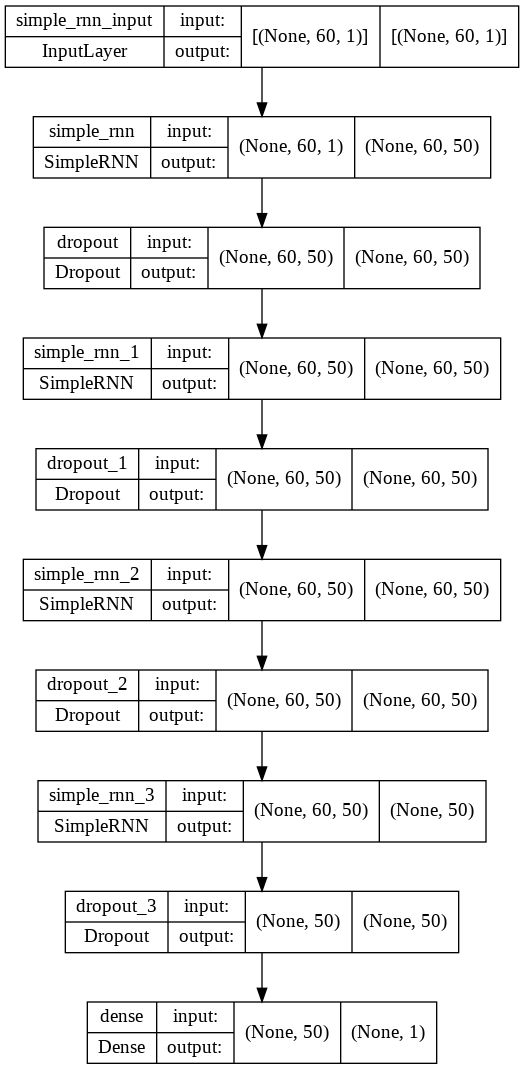

In [15]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(regressor, to_file='NN-mnist.png', show_shapes=True)

In [16]:
def create_model_check_point_callback(checkpoint_path,monitor='val_loss'):
    """
    Takes the path where to save the best model weights obtained during training.
    """
    model_checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(
        
        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb
ModelCheckPoint_model_cb=create_model_check_point_callback('ModelCheckPoints/model.ckpt')    

In [35]:
regressor.fit(x_train,
              y_train,epochs = 80,
              batch_size =32,
              )

Epoch 1/80
38/38 [==============================] - 9s 176ms/step - loss: 0.6039
Epoch 2/80
38/38 [==============================] - 7s 178ms/step - loss: 0.3504
Epoch 3/80
38/38 [==============================] - 7s 178ms/step - loss: 0.2705
Epoch 4/80
38/38 [==============================] - 8s 201ms/step - loss: 0.2060
Epoch 5/80
38/38 [==============================] - 7s 174ms/step - loss: 0.1463
Epoch 6/80
38/38 [==============================] - 7s 176ms/step - loss: 0.1300
Epoch 7/80
38/38 [==============================] - 8s 203ms/step - loss: 0.1095
Epoch 8/80
38/38 [==============================] - 7s 178ms/step - loss: 0.0889
Epoch 9/80
38/38 [==============================] - 7s 173ms/step - loss: 0.0753
Epoch 10/80
38/38 [==============================] - 7s 174ms/step - loss: 0.0654
Epoch 11/80
38/38 [==============================] - 7s 176ms/step - loss: 0.0575
Epoch 12/80
38/38 [==============================] - 7s 178ms/step - loss: 0.0508
Epoch 13/80
38/38 [======

In [36]:
data_test_stoke = data_test.iloc[:,1:2]

In [37]:
dataset = pd.concat((data_train['Open'],data_test['Open']),axis =0)
inputs = dataset[len(dataset)-len(data_test)-60:].values
inputs =inputs.reshape(-1,1)
inputs =sc.transform(inputs)

x_test =[]
for i in range(60,80):
    x_test.append(inputs[i-60:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [38]:
predict_price = regressor.predict(x_test)                 
predict_price = sc.inverse_transform(predict_price)

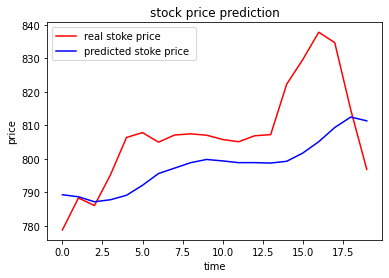

In [39]:
plt.plot(data_test_stoke,color='red',label = 'real stoke price ')
plt.plot(predict_price,color='blue',label = 'predicted stoke price ')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [42]:
regressor.save('stock_price.h5')
